# Assignment 2: Dimensionality and PCA (10 pts)

In [1]:
# Install torchextractor for facilitating feature extraction
!pip install torchextractor

# Import packages
import warnings
import sys
if not sys.warnoptions:
    warnings.simplefilter('ignore')

import torch
from torchvision import models, transforms
import torchextractor as tx
from PIL import Image
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm

from sklearn.decomposition import PCA

In [2]:
# Download the dataset
!gdown 1q5mPgOpEsWx4x_FeuZWu-8HfsdGr-aLS
# Extract the dataset and remove the tar file
!mkdir -p natural_scenes_demo && tar -xzf natural_scenes_demo.tar.gz -C natural_scenes_demo
!rm natural_scenes_demo.tar.gz

Downloading...
From (original): https://drive.google.com/uc?id=1q5mPgOpEsWx4x_FeuZWu-8HfsdGr-aLS
From (redirected): https://drive.google.com/uc?id=1q5mPgOpEsWx4x_FeuZWu-8HfsdGr-aLS&confirm=t&uuid=b7460033-3cb3-42a9-824a-523107ebee38
To: /content/natural_scenes_demo.tar.gz
100% 395M/395M [00:03<00:00, 132MB/s]
tar: Ignoring unknown extended header keyword 'LIBARCHIVE.xattr.com.apple.quarantine'
tar: Ignoring unknown extended header keyword 'LIBARCHIVE.xattr.com.apple.macl'
tar: Ignoring unknown extended header keyword 'SCHILY.fflags'
tar: Ignoring unknown extended header keyword 'LIBARCHIVE.xattr.com.apple.quarantine'
tar: Ignoring unknown extended header keyword 'LIBARCHIVE.xattr.com.apple.FinderInfo'
tar: Ignoring unknown extended header keyword 'LIBARCHIVE.xattr.com.apple.quarantine'
tar: Ignoring unknown extended header keyword 'LIBARCHIVE.xattr.com.apple.provenance'
tar: Ignoring unknown extended header keyword 'LIBARCHIVE.xattr.com.apple.lastuseddate#PS'
tar: Ignoring unknown exte

The layer activations from Alexnet fc7 of 1000 images can be extracted with this demo code. Note here libary `torchextractor` is used to faciliate the feature extraction.

In [3]:
# Define device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Load a pre-trained model
model = models.alexnet(weights='IMAGENET1K_V1')
model.to(device).eval()

# Define layers to extract
layers = ["classifier.4"]  # e.g. AlexNet fc7

# Wrap the model with torchextractor
model = tx.Extractor(model, layers)

# Define image preprocessing
preprocess = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

# Read the image information
df = pd.read_csv('natural_scenes_demo/stimulus_data.csv')
# Initialize list to hold activations
activations_list = []

# Loop over images in the dataset to extract activations
for img_path in tqdm(df['image_path']):
    # Preprocess the image and add batch dimension
    image = preprocess(Image.open(img_path)).unsqueeze(0).to(device)
    # Forward pass through the model
    with torch.no_grad():
        _, activations = model(image)
    # Store the activations
    activations_list.append(activations['classifier.4'].squeeze().data.cpu().numpy())

# Convert list to array
activations_fc7 = np.array(activations_list)

Downloading: "https://download.pytorch.org/models/alexnet-owt-7be5be79.pth" to /root/.cache/torch/hub/checkpoints/alexnet-owt-7be5be79.pth


100%|██████████| 233M/233M [00:04<00:00, 59.0MB/s]
100%|██████████| 1000/1000 [01:16<00:00, 13.02it/s]


#### ✏️ Do it yourself (2 pt):
Estimate the dimensionality of activations from layer 7 by computing its rank. \
_Hint: use `np.linalg.matrix_rank` to compute rank_

In [13]:
# Insert your code here
activations_centered = activations_fc7 - np.mean(activations_fc7, axis=0)
dim_rank = np.linalg.matrix_rank(activations_centered)

print(f'Rank of the matrix is: {dim_rank}')

Rank of the matrix is: 999


This demo performs PCA on fc7 features of the 1000 images.

In [14]:
# Set up a PCA instance
pca = PCA()
# Fit PCA on the activations
pca.fit(activations_fc7)

PCA()

#### ✏️ Do it yourself (2 pt):
Estimate the dimensionality of activations by setting the number of components explaining 85% total variance. \
_Hint: use `pca.explained_variance_ratio`_

In [16]:
# Insert your code here
cumulative_variance = np.cumsum(pca.explained_variance_ratio_)
dim_thresh = np.argmax(cumulative_variance >= 0.85) + 1

print(f'Number of components to explain 85% variance: {dim_thresh}')

Number of components to explain 85% variance: 353


#### ✏️ Do it yourself (2 pt):
Estimate the dimensionality of activations by computing its effective dimensionality. \
_Hint: use `pca.explained_variance`_

In [17]:
# Insert your code here
sum_lambda = np.sum(pca.explained_variance_)
sum_lambda_squared = np.sum(pca.explained_variance_ ** 2)
dim_eff = (sum_lambda ** 2) / sum_lambda_squared


print(f'The effective dimensionality is: {dim_eff}')

The effective dimensionality is: 108.3676528930664


#### ✏️ Do it yourself (4 pts):
Plot the reconstruction error as the function of number of PCs seperately for the training and test sets. \
The first 800 images are the training set. The last 200 images are the test set. \
Only show the plot of first 20 PCs. \
_Hint: Use `pca.transform` to project data onto the latent dimensions; use `pca.inverse_transform` to decode from the latent dimensions_

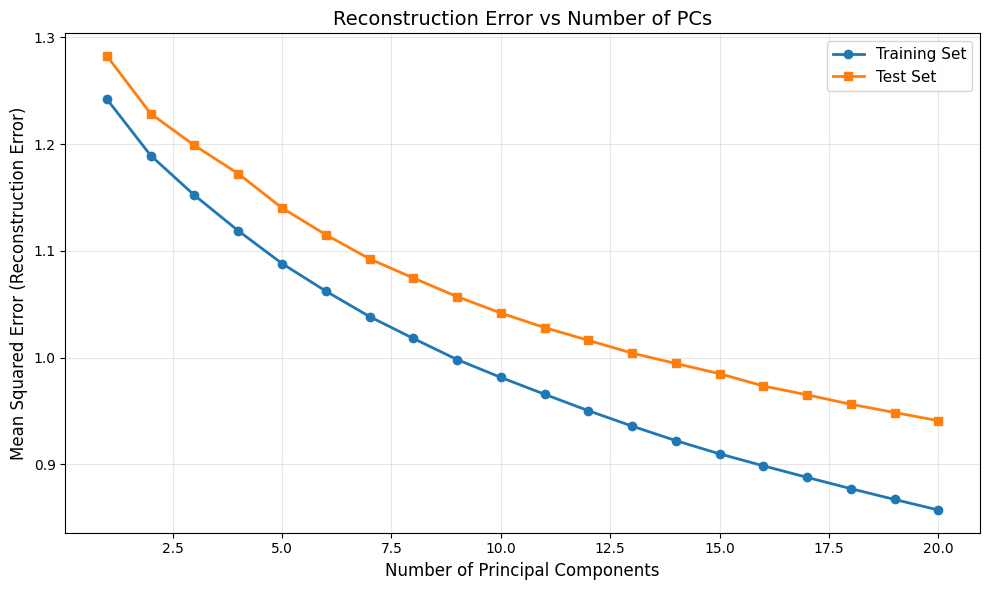

In [18]:
# First 800 images
X_train = activations_fc7[:800]
# Last 200 images
X_test  = activations_fc7[800:]

# Insert your code here
n_components = 20
train_errors = []
test_errors = []

pca_cv = PCA()
pca_cv.fit(X_train)

for n in range(1, n_components + 1):

    X_train_transformed = pca_cv.transform(X_train)[:, :n]
    X_test_transformed = pca_cv.transform(X_test)[:, :n]


    X_train_reconstructed = X_train_transformed @ pca_cv.components_[:n, :] + pca_cv.mean_
    X_test_reconstructed = X_test_transformed @ pca_cv.components_[:n, :] + pca_cv.mean_

    # mean squared error
    train_error = np.mean((X_train - X_train_reconstructed) ** 2)
    test_error = np.mean((X_test - X_test_reconstructed) ** 2)

    train_errors.append(train_error)
    test_errors.append(test_error)

plt.figure(figsize=(10, 6))
plt.plot(range(1, n_components + 1), train_errors, marker='o', label='Training Set', linewidth=2)
plt.plot(range(1, n_components + 1), test_errors, marker='s', label='Test Set', linewidth=2)
plt.xlabel('Number of Principal Components', fontsize=12)
plt.ylabel('Mean Squared Error (Reconstruction Error)', fontsize=12)
plt.title('Reconstruction Error vs Number of PCs', fontsize=14)
plt.legend(fontsize=11)
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()